In [108]:
# Import packages that I will need for this task

import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler



I'm using a new notebook to model.. as I don't want rely on my laptop memory for the entire data set. 
So The final data frame was saved as a CSV file and now I can just get it again easialy. 

In [109]:
#bring the file I saved from the scrapping process
feat=pd.read_csv('TDF_Feat')

In [196]:
#check the columns
feat.columns

Index(['Unnamed: 0', 'Year', 'Stage', 'Distance', 'StageScore', 'Rnk', 'Rider',
       'Age', 'Team', 'Time', 'Winnin Avg_speed', 'R_TT', 'R_onedayrace',
       'R_climb', 'R_Sprint', 'R_GC', 'R_height', 'R_weight', 'Winner', 'Gap'],
      dtype='object')

In [111]:
feat = feat[['Distance', 'StageScore', 'Rnk', 'Age', 'Time',
       'Winnin Avg_speed', 'R_TT', 'R_onedayrace', 'R_climb', 'R_Sprint','R_fit',
       'Gap']]

In [112]:
feat.drop(['Time'], axis=1)

,Distance,StageScore,Rnk,Age,Winnin Avg_speed,R_TT,R_onedayrace,R_climb,R_Sprint,R_fit,Gap
0,163,0,1,29,34.560,919,1353,836,1588,0.377778,0
1,163,0,2,26,34.560,919,1353,836,1588,0.377778,0
2,163,0,3,27,34.560,919,1353,836,1588,0.377778,0
3,163,0,4,27,34.560,919,1353,836,1588,0.377778,0
4,163,0,5,23,34.560,919,1353,836,1588,0.377778,0
...,...,...,...,...,...,...,...,...,...,...,...
209222,170,107,169,33,42.064,466,401,41,1409,0.432292,0
209223,170,107,170,25,42.064,148,1224,201,4592,0.406061,0
209224,170,107,170,25,42.064,148,1224,201,4592,0.406061,0
209225,170,107,171,29,42.064,1280,8791,3038,3505,0.423913,0


In [113]:
feat

,Distance,StageScore,Rnk,Age,Time,Winnin Avg_speed,R_TT,R_onedayrace,R_climb,R_Sprint,R_fit,Gap
0,163,0,1,29,0 days 04:42:58.000000000,34.560,919,1353,836,1588,0.377778,0
1,163,0,2,26,0 days 00:00:02.000000000,34.560,919,1353,836,1588,0.377778,0
2,163,0,3,27,0 days 00:00:00.000000000,34.560,919,1353,836,1588,0.377778,0
3,163,0,4,27,0 days 00:00:00.000000000,34.560,919,1353,836,1588,0.377778,0
4,163,0,5,23,0 days 00:00:00.000000000,34.560,919,1353,836,1588,0.377778,0
...,...,...,...,...,...,...,...,...,...,...,...,...
209222,170,107,169,33,0 days 00:00:02.000000000,42.064,466,401,41,1409,0.432292,0
209223,170,107,170,25,0 days 00:00:02.000000000,42.064,148,1224,201,4592,0.406061,0
209224,170,107,170,25,0 days 00:00:02.000000000,42.064,148,1224,201,4592,0.406061,0
209225,170,107,171,29,0 days 00:00:02.000000000,42.064,1280,8791,3038,3505,0.423913,0


In [114]:
featcorr=feat.corr()

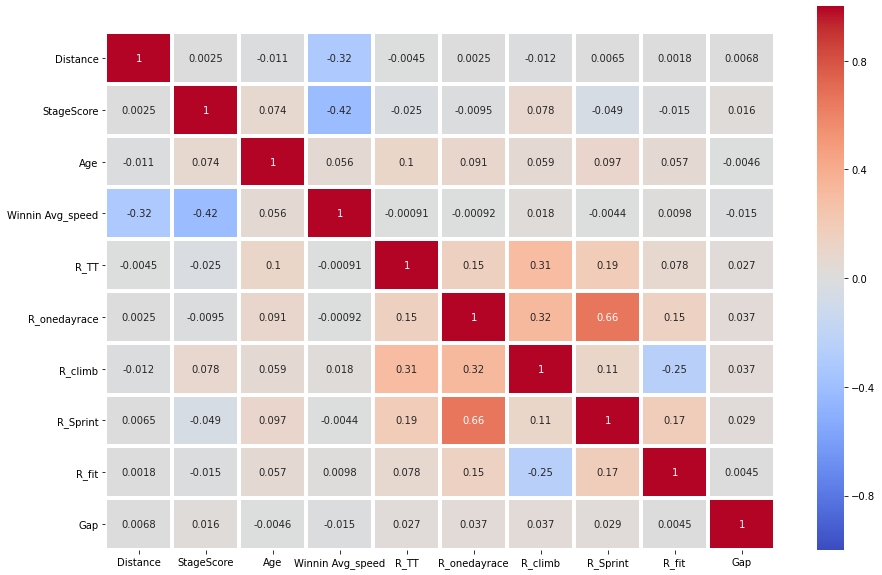

In [115]:
plt.figure(figsize=(15,10))
sns.heatmap(featcorr,cmap='coolwarm', center=0,annot=True, linewidths=3, vmin=-1, vmax=1)
# Don't worry about this, work-around for matplotlib issue where top
plt.ylim(len(featcorr.columns),-0.5, -0.5)

plt.show()

This makes sense, we can see that the longer and harder the stage the lower the average speed is. 
How a good GC rider is also a good climber.
However I want to have good features.. and to me it seems that GC(Riders able to get over all victories) is highly correlated to other rider features, so avoid overfitting on that I'm dropping this feature.

In [116]:
#First we create a matrix of zeroes that we will use like a mask to place over the upper triangle of our heatmap
mask = np.zeros_like(featcorr, dtype=np.bool)

# np.triu_indices_from returns the upper triangle, which we are setting to True
mask[np.triu_indices_from(mask)] = True

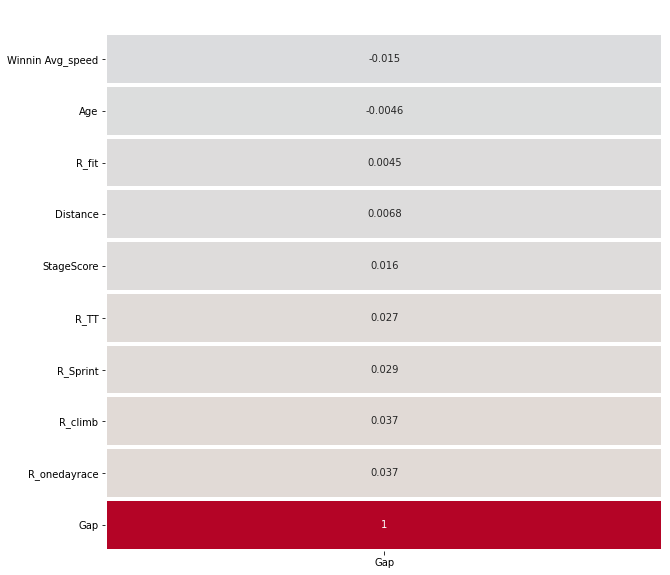

In [117]:
plt.figure(figsize=(10,10))
sns.heatmap(featcorr[['Gap']].sort_values(by='Gap'), cbar = False ,cmap='coolwarm', center=0, annot=True, linewidths = 3)
plt.ylim(len(featcorr.columns),-0.5, -0.5)
plt.show()

#### Now it appears that the correlations are not so strong anymore. 

Time to deal with what I expected to be the worst part of this project, the imbalanced data

In [118]:
#Let me check the distribution of outcomes
#I already know that this is very imbalanced
a=feat[feat['Gap']==1].shape
b=feat[feat['Gap']==0].shape

In [119]:
print(f'Qty of Posivite Outcome: {a[0]}')
print(f'Qty of Posivite Outcome: {b[0]}')
print(f'Balance ratio = {a[0]/b[0]}')

Qty of Posivite Outcome: 542
Qty of Posivite Outcome: 208685
Balance ratio = 0.00259721589956154


### So I now need to figure out how to deal with such imbalanced data

I first want to check what a Logist regression would look like

In [120]:
# Define our X and y
X = feat.drop(columns=['Gap','Rnk','Time'])
y = feat['Gap']

# adding the column of ones
X_withconstant = sm.add_constant(X)

C:\Users\renan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [122]:
from sklearn.model_selection import train_test_split

# Define our X and y
X = feat.drop(columns=['Gap','Rnk','Time'])
y = feat['Gap']

# Create a train/test split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# 1. Instantiate and fit model
my_logit = LogisticRegression()
my_logit.fit (X_train, y_train)

#predicttion on trainset
my_logit_pred=my_logit.predict(X_test)




# 3. Score model

print(classification_report(y_test, my_logit_pred))
pd.DataFrame(my_logit_pred)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41736
           1       0.00      0.00      0.00       110

    accuracy                           1.00     41846
   macro avg       0.50      0.50      0.50     41846
weighted avg       0.99      1.00      1.00     41846



C:\Users\renan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0
0,0
1,0
2,0
3,0
4,0
...,...
41841,0
41842,0
41843,0
41844,0


### With such imbalanced data I expected the score to be this high, can't really trust it. 

one way to deal with this is to get more class 1 on the trainning data set, to actually teach the model how to read the outcome 1. 
So I need to put a threshold that pulls more class 1. 


In [124]:
# Just demonstrating the diffence in the data set

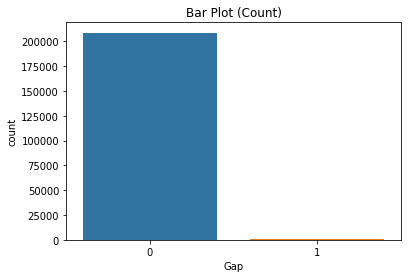

In [125]:
sns.countplot(feat['Gap'])
plt.title("Bar Plot (Count)");

In [126]:
# Make probabilistic predictions (scores)
y_proba = my_logit.predict_proba(X_test)[:,1]



# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.02)
y_threshold = np.where(y_proba > 0.02, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.0
Recall score: 0.0

Threshold of 0.2:
Precision score: 0.0196078431372549
Recall score: 0.06363636363636363


C:\Users\renan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ok, I guess I made it very clear that the data is too imbalanced to acctually get usefull information from it. 
#### So let me try a few techniques to deal with it.

# Technique 1 - SMOTE

Smote will basically create synthetic observations of the results that are less common, in this case... winners with a gap.

It does so by identifying the  k-nearest-neighbors and randomly choosing one to create similar, but slightly different, observations.

## SMOTE should always be aplyied after the train,test split. 

In [127]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics

In [128]:
# I already have my X an y defined, but I canb still play around with the traintest ratio

# Define our X and y
X = feat.drop(columns=['Gap','Rnk','Time'])
y = feat['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [129]:
#The sampling Strategy defines the ratio I'd like to have from the minority class to the majority class
# Note that only the Train data is being oversampled
sm = SMOTE(sampling_strategy=0.2)
x_res, y_res = sm.fit_sample(X_train, y_train)


In [130]:
#Now lets see what we get from a ramdom forest classifier

clf_rf = RandomForestClassifier(n_estimators=25)
clf_rf.fit(x_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [131]:
y_pred=clf_rf.predict(X_test)

In [132]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## The high accuracy here really only tells me that I can predict the majority class "0" very easily. 
# I need to check how it's doing on the minority class

Accuracy: 0.9967499880514267


In [133]:
print('Validation Results')
print(clf_rf.score(X_test, y_test))
print(recall_score(y_test, clf_rf.predict(X_test)))
print('\nTest Results')
print(clf_rf.score(X, y))
print(recall_score(y_test, clf_rf.predict(X_test)))

Validation Results
0.9967499880514267
0.34545454545454546

Test Results
0.9984705606828946
0.34545454545454546


As seem above the high precision is present just because it's so easy to predict the majority clas, as for the recall, we can see that predicting the positive class "1" is not as easy. 
I will have to deal of the imbalanced data in some way. 

My train data is still unbalanced. But much less them before, and results on the my y_test improved a lot.


In [134]:
# Find the important features

feature_imp = pd.Series(clf_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

Winnin Avg_speed    0.146714
R_Sprint            0.127589
R_climb             0.126555
Distance            0.121121
StageScore          0.107710
R_TT                0.102408
R_onedayrace        0.095689
R_fit               0.087625
Age                 0.084588
dtype: float64

No handles with labels found to put in legend.


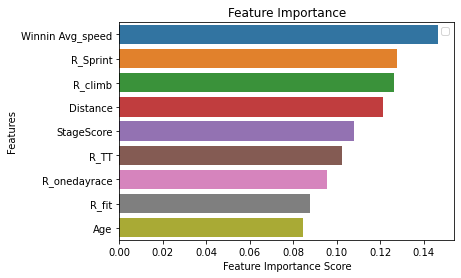

In [135]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()

I can see here that the speed is higly correlated, and that is quite expected, riding fast we win races.
However I want to predict what other attributes to a race event or rider make it easy to win with a gap over 5 seconds. 
I will have to drop speed to avoid confusion and add strengh to other features. 

In [136]:
# I already have my X an y defined, but I canb still play around with the traintest ratio

# Define our X and y
X = feat.drop(columns=['Gap','Rnk','Time','Winnin Avg_speed'])
y = feat['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

Using the Smote method to upsample my train data minority class to a proportion of 20% of the entire train data, still imbalanced but much less then original data

In [137]:
#The sampling Strategy defines the ratio I'd like to have from the minority class to the majority class
# Note that only the Train data is being oversampled
sm = SMOTE(sampling_strategy=0.2)
x_res, y_res = sm.fit_sample(X_train, y_train)


In [138]:
#Now lets see what we get from a ramdom forest classifier

clf_rf = RandomForestClassifier(n_estimators=25)
clf_rf.fit(x_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [139]:
y_pred=clf_rf.predict(X_test)

In [140]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9905845242078096


In [141]:
print('Validation Results')
print(clf_rf.score(X_test, y_test))
print(recall_score(y_test, clf_rf.predict(X_test)))
print('\nTest Results')
print(clf_rf.score(X, y))
print(recall_score(y_test, clf_rf.predict(X_test)))

Validation Results
0.9905845242078096
0.36363636363636365

Test Results
0.9936815038212086
0.36363636363636365


The results fpr recall don't increase all that much

In [142]:
# Find the important features

feature_imp = pd.Series(clf_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

Distance        0.168538
R_Sprint        0.134763
StageScore      0.131324
R_onedayrace    0.126497
R_climb         0.125822
R_TT            0.116416
Age             0.100464
R_fit           0.096175
dtype: float64

No handles with labels found to put in legend.


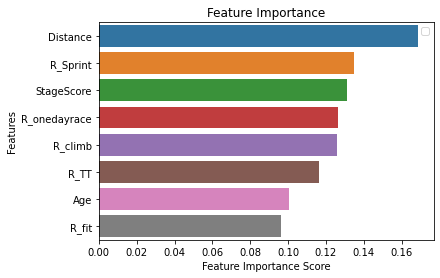

In [143]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()

One interesting finding from this step is how the total distance of a stage might benefit the breakaway

In [144]:
#Now lets see what we get from a ramdom forest classifier
estimators=range(1,30)
valScore=[]
valrecall=[]
testScore=[]
testrecall=[]
accuraccy=[]

for i in estimators:
    clf_rf = RandomForestClassifier(n_estimators=i)
    clf_rf.fit(x_res, y_res)
    
    y_pred=clf_rf.predict(X_test)

   
    valScore.append(clf_rf.score(X_test, y_test))
    valrecall.append(recall_score(y_test, clf_rf.predict(X_test)))
    
    testScore.append(clf_rf.score(X, y))
    testrecall.append(recall_score(y_test, clf_rf.predict(X_test)))
    
    accuraccy.append(metrics.accuracy_score(y_test, y_pred))

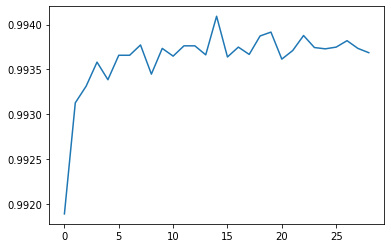

In [146]:
plt.figure()
#plt.plot(testrecall)
plt.plot(testScore)
plt.show()

In [147]:
# I already have my X an y defined, but I canb still play around with the traintest ratio

# Define our X and y
X = feat.drop(columns=['Gap','Rnk','Time'])
y = feat['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=1)

#The sampling Strategy defines the ratio I'd like to have from the minority class to the majority class
# Note that only the Train data is being oversampled
sm = SMOTE(sampling_strategy=0.2)
X_res, y_res = sm.fit_sample(X_train, y_train)


In [148]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import  GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix




In [149]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {'min_samples_split': [3, 5, 10], 'n_estimators' : [100, 300],'max_depth': [3, 5, 15, 25]}

scorers = {'precision_score': make_scorer(precision_score),'recall_score': make_scorer(recall_score),'accuracy_score': make_scorer(accuracy_score)}

In [150]:

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_res.values, y_res.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [152]:
############-Don't run this.. takes forever-#############################

##########-Whitout Speed-###################

#grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     20845        28
pos        32        18


### Despite acctually predicting the minority class with some accuracy, this an extremely expensive model to run. 

This still pretty low, so I'll try a diffent technique, let's undersample the dominant class... or cut some 0s out of this


#### So it seems that my main issue here is the lack of features.. maybe I can colect nome more

In [178]:
feat2=pd.read_csv('data/TDF_modeltf')

C:\Users\renan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [179]:
feat2

,Unnamed: 0,Year,Stage,Distance,StageScore,Rnk,Rider,Age,Team,Time,Winnin Avg_speed,R_TT,R_onedayrace,R_climb,R_Sprint,R_GC,R_height,R_weight,Winner,Gap
0,0,1980,10,163,0,1,Priem CeesTI Raleigh - Creda,29,TI Raleigh - Creda,0 days 04:42:58.000000000,34.560,919,1353,836,1588,1646,180,68,1,0
1,1,1980,10,163,0,2,Osmont JacquesBoston - IFI - Mavic,26,Boston - IFI - Mavic,0 days 00:00:02.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
2,2,1980,10,163,0,3,Bertin YvonRenault - Gitane - Campagnolo,27,Renault - Gitane - Campagnolo,0 days 00:00:00.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
3,3,1980,10,163,0,4,Raas JanTI Raleigh - Creda,27,TI Raleigh - Creda,0 days 00:00:00.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
4,4,1980,10,163,0,5,Tackaert WilliamDaf Trucks - Lejeune - PZ,23,Daf Trucks - Lejeune - PZ,0 days 00:00:00.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209222,209222,2019,9,170,107,169,Roger-Kluge,33,Lotto Soudal,0 days 00:00:02.000000000,42.064,466,401,41,1409,351,192,83,0,0
209223,209223,2019,9,170,107,170,Caleb-Ewan,25,Lotto Soudal,0 days 00:00:02.000000000,42.064,148,1224,201,4592,201,165,67,0,0
209224,209224,2019,9,170,107,170,Caleb-Ewan,25,Lotto Soudal,0 days 00:00:02.000000000,42.064,148,1224,201,4592,201,165,67,0,0
209225,209225,2019,9,170,107,171,Peter-Sagan,29,BORA - hansgrohe,0 days 00:00:02.000000000,42.064,1280,8791,3038,3505,1496,184,78,0,0


### The data set is just too hard to predict on I need more features

Let's test a smallet data set with less features


In [182]:
data2=pd.read_csv('data/TDF2.csv')

In [209]:
# I already have my X an y defined, but I canb still play around with the traintest ratio

# Define our X and y
X = data2.drop(columns=['Gap','Rnk','Time','Winnin Avg_speed','Rider','Team'])
y = data2['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)


In [214]:
#Now lets see what we get from a ramdom forest classifier

clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [215]:
print('Validation Results')
print(clf_rf.score(X_test, y_test))
print(recall_score(y_test, clf_rf.predict(X_test)))
print('\nTest Results')
print(clf_rf.score(X, y))
print(recall_score(y_test, clf_rf.predict(X_test)))

Validation Results
0.9965034965034965
0.5

Test Results
0.9992997198879552
0.5


### Let's add some virtual data points to test if the score would improve. 


In [105]:
data3=pd.read_csv('TDF Virtual Data.csv')


In [399]:
data3.columns

Index(['index', 'Year', 'Stage', 'Distance', 'StageScore', 'Rnk', 'Rider',
       'Age', 'Team', 'Time', 'Winnin Avg_speed', 'R_TT', 'R_onedayrace',
       'R_climb', 'R_Sprint', 'R_GC', 'R_height', 'R_weight', 'Winner', 'Gap',
       'Break 50km', '50k gap sec', '50k Riders#', 'Break 40km', '40k gap sec',
       '40km Rider#', 'Break 30km', '30k gap sec', '30km rider # ',
       'Break 20km', '20k gap sec', '20km rider #', 'Break 10km',
       '10k gap sec', '10km Rider#', 'Break 5km', '5k gap sec', '5km rider#',
       'Break 3km', '3k gap sec', '3km Rider#', 'Break 2km', '2k gap sec',
       '2km Rider#', 'Break 1km', '1k gap sec', '1km rider #'],
      dtype='object')

In [400]:
data2=data3.append(data3)

In [401]:
data2=data2.append(data3)

In [413]:
data2['Gap'].value_counts()

0    4269
1      15
Name: Gap, dtype: int64

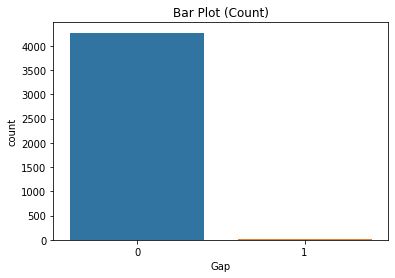

In [414]:
sns.countplot(data2['Gap'])
plt.title("Bar Plot (Count)");

In [415]:
data2.columns

Index(['index', 'Year', 'Stage', 'Distance', 'StageScore', 'Rnk', 'Rider',
       'Age', 'Team', 'Time', 'Winnin Avg_speed', 'R_TT', 'R_onedayrace',
       'R_climb', 'R_Sprint', 'R_GC', 'R_height', 'R_weight', 'Winner', 'Gap',
       'Break 50km', '50k gap sec', '50k Riders#', 'Break 40km', '40k gap sec',
       '40km Rider#', 'Break 30km', '30k gap sec', '30km rider # ',
       'Break 20km', '20k gap sec', '20km rider #', 'Break 10km',
       '10k gap sec', '10km Rider#', 'Break 5km', '5k gap sec', '5km rider#',
       'Break 3km', '3k gap sec', '3km Rider#', 'Break 2km', '2k gap sec',
       '2km Rider#', 'Break 1km', '1k gap sec', '1km rider #'],
      dtype='object')

In [416]:
data2.isnull().sum()

index               0
Year                0
Stage               0
Distance            0
StageScore          0
Rnk                 0
Rider               0
Age                 0
Team                0
Time                0
Winnin Avg_speed    0
R_TT                0
R_onedayrace        0
R_climb             0
R_Sprint            0
R_GC                0
R_height            0
R_weight            0
Winner              0
Gap                 0
Break 50km          0
50k gap sec         0
50k Riders#         0
Break 40km          0
40k gap sec         0
40km Rider#         0
Break 30km          0
30k gap sec         0
30km rider #        0
Break 20km          0
20k gap sec         0
20km rider #        0
Break 10km          0
10k gap sec         0
10km Rider#         0
Break 5km           0
5k gap sec          0
5km rider#          0
Break 3km           0
3k gap sec          0
3km Rider#          0
Break 2km           0
2k gap sec          0
2km Rider#          0
Break 1km           0
1k gap sec

In [433]:

# Define our X and y
X = data2.drop(columns=['Gap','Rnk','Time','Winnin Avg_speed','Rider','Team','Winner','index','Year','Stage','R_weight','R_height'])
y = data2['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

#The sampling Strategy defines the ratio I'd like to have from the minority class to the majority class
# Note that only the Train data is being oversampled
sm = SMOTE(sampling_strategy=0.5)
X_res, y_res = sm.fit_sample(X_train, y_train)


In [434]:
#Now lets see what we get from a ramdom forest classifier

clf_rf = RandomForestClassifier(n_estimators=25)
clf_rf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### I defined a grid search function to quickly be able to run models and print the main evaluators.

In [17]:

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_res.values, y_res.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [436]:
########### - With Speed - ####################

# Now I'm runiing the SVM using the speed feature, maybe it will help

grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      1062         3
pos         0         6


In [422]:
len(X_res.columns)

35

In [423]:
# Find the important features

feature_imp = pd.Series(clf_rf.feature_importances_,index=X_res.columns).sort_values(ascending=False)
feature_imp

R_Sprint         0.165620
R_TT             0.096298
R_onedayrace     0.064496
R_GC             0.055499
R_climb          0.048957
Age              0.047950
40km Rider#      0.043133
3k gap sec       0.042496
20k gap sec      0.041986
2km Rider#       0.040461
30km rider #     0.035748
30k gap sec      0.033813
10km Rider#      0.033114
50k gap sec      0.030836
StageScore       0.030684
40k gap sec      0.027853
20km rider #     0.027723
10k gap sec      0.026458
Distance         0.018690
5k gap sec       0.017366
3km Rider#       0.016474
2k gap sec       0.013497
5km rider#       0.013240
50k Riders#      0.010770
1km rider #      0.006956
1k gap sec       0.004707
Break 5km        0.001735
Break 2km        0.001733
Break 50km       0.001561
Break 3km        0.000144
Break 40km       0.000000
Break 30km       0.000000
Break 10km       0.000000
Break 1km        0.000000
Break 20km       0.000000
dtype: float64

No handles with labels found to put in legend.


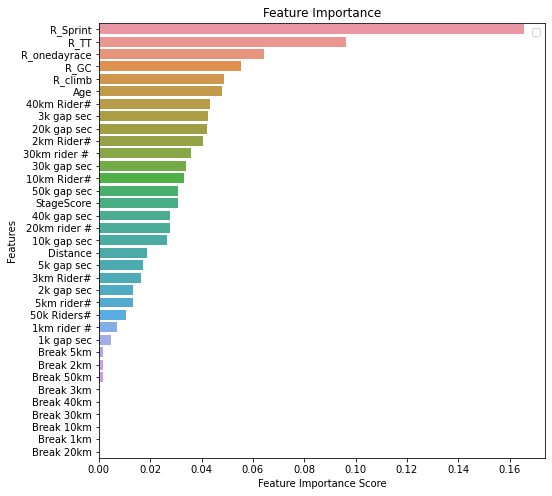

In [424]:
%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(8, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()

### Let me now try the same data on a LogReg

In [216]:
# This improve the results, so maybe I need more data

In [166]:
# I already have my X an y defined, but I canb still play around with the traintest ratio

# Define our X and y
X = feat.drop(columns=['Gap','Rnk','Time','Winnin Avg_speed'])
y = feat['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=1)

#The sampling Strategy defines the ratio I'd like to have from the minority class to the majority class
# Note that only the Train data is being oversampled
sm = SMOTE(sampling_strategy=0.5)
X_res, y_res = sm.fit_sample(X_train, y_train)


In [437]:
from sklearn import preprocessing
preprocessing.StandardScaler().fit(X_res)

# 1. Instantiate and fit model
my_logit = LogisticRegression()
my_logit.fit (X_res, y_res)

#predicttion on trainset
my_logit_pred=my_logit.predict(X_test)




# 3. Score model

print(classification_report(y_test, my_logit_pred))
pd.DataFrame(my_logit_pred)


              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1065
           1       0.01      0.17      0.02         6

    accuracy                           0.88      1071
   macro avg       0.50      0.53      0.48      1071
weighted avg       0.99      0.88      0.93      1071



C:\Users\renan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,0
0,0
1,0
2,0
3,0
4,0
...,...
1066,0
1067,0
1068,0
1069,0


### Sample reduction using only the race winners

In [159]:
feat=pd.read_csv('TDF_modeltf')

C:\Users\renan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [160]:
feat

,Unnamed: 0,Year,Stage,Distance,StageScore,Rnk,Rider,Age,Team,Time,Winnin Avg_speed,R_TT,R_onedayrace,R_climb,R_Sprint,R_GC,R_height,R_weight,Winner,Gap
0,0,1980,10,163,0,1,Priem CeesTI Raleigh - Creda,29,TI Raleigh - Creda,0 days 04:42:58.000000000,34.560,919,1353,836,1588,1646,180,68,1,0
1,1,1980,10,163,0,2,Osmont JacquesBoston - IFI - Mavic,26,Boston - IFI - Mavic,0 days 00:00:02.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
2,2,1980,10,163,0,3,Bertin YvonRenault - Gitane - Campagnolo,27,Renault - Gitane - Campagnolo,0 days 00:00:00.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
3,3,1980,10,163,0,4,Raas JanTI Raleigh - Creda,27,TI Raleigh - Creda,0 days 00:00:00.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
4,4,1980,10,163,0,5,Tackaert WilliamDaf Trucks - Lejeune - PZ,23,Daf Trucks - Lejeune - PZ,0 days 00:00:00.000000000,34.560,919,1353,836,1588,1646,180,68,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209222,209222,2019,9,170,107,169,Roger-Kluge,33,Lotto Soudal,0 days 00:00:02.000000000,42.064,466,401,41,1409,351,192,83,0,0
209223,209223,2019,9,170,107,170,Caleb-Ewan,25,Lotto Soudal,0 days 00:00:02.000000000,42.064,148,1224,201,4592,201,165,67,0,0
209224,209224,2019,9,170,107,170,Caleb-Ewan,25,Lotto Soudal,0 days 00:00:02.000000000,42.064,148,1224,201,4592,201,165,67,0,0
209225,209225,2019,9,170,107,171,Peter-Sagan,29,BORA - hansgrohe,0 days 00:00:02.000000000,42.064,1280,8791,3038,3505,1496,184,78,0,0


In [161]:
winners=feat[feat['Rnk']==1]

In [162]:
winners.head(5)

,Unnamed: 0,Year,Stage,Distance,StageScore,Rnk,Rider,Age,Team,Time,Winnin Avg_speed,R_TT,R_onedayrace,R_climb,R_Sprint,R_GC,R_height,R_weight,Winner,Gap
0,0,1980,10,163,0,1,Priem CeesTI Raleigh - Creda,29,TI Raleigh - Creda,0 days 04:42:58.000000000,34.56,919,1353,836,1588,1646,180,68,1,0
115,115,1980,11,51,0,1,Zoetemelk JoopTI Raleigh - Creda,33,TI Raleigh - Creda,0 days 01:10:24.000000000,43.47,919,1353,836,1588,1646,180,68,1,1
229,229,1980,12,194,0,1,Knetemann GerrieTI Raleigh - Creda,29,TI Raleigh - Creda,0 days 05:45:24.000000000,33.70,919,1353,836,1588,1646,180,68,1,0
342,342,1980,13,200,100,1,Martin RaymondMiko - Mercier - Vivagel,31,Miko - Mercier - Vivagel,0 days 06:27:32.000000000,30.97,919,1353,836,1588,1646,180,68,1,1
443,443,1980,14,189,0,1,Peeters LudoIjsboerke - Warncke Eis - Koga Miyata,26,Ijsboerke - Warncke Eis - Koga Miyata,0 days 05:34:49.000000000,33.87,919,1353,836,1588,1646,180,68,1,1


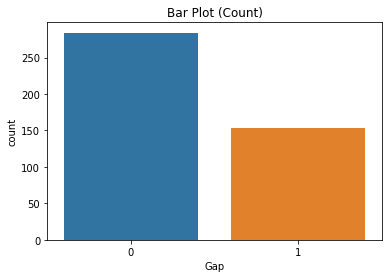

In [163]:
sns.countplot(winners['Gap'])
plt.title("Bar Plot (Count)");

In [171]:
winners.head(2)

,Unnamed: 0,Year,Stage,Distance,StageScore,Rnk,Rider,Age,Team,Time,Winnin Avg_speed,R_TT,R_onedayrace,R_climb,R_Sprint,R_GC,R_height,R_weight,Winner,Gap
0,0,1980,10,163,0,1,Priem CeesTI Raleigh - Creda,29,TI Raleigh - Creda,0 days 04:42:58.000000000,34.56,919,1353,836,1588,1646,180,68,1,0
115,115,1980,11,51,0,1,Zoetemelk JoopTI Raleigh - Creda,33,TI Raleigh - Creda,0 days 01:10:24.000000000,43.47,919,1353,836,1588,1646,180,68,1,1


In [173]:
winners.drop(columns=['Year','Stage','Unnamed: 0', 'Rider', 'Team', 'Time', 'Winner', 'Rnk'],  inplace=True)

C:\Users\renan\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [174]:
# Check if there is much change to the correlation in this case, I assume there shouldn't be

featcorr=winners.corr()

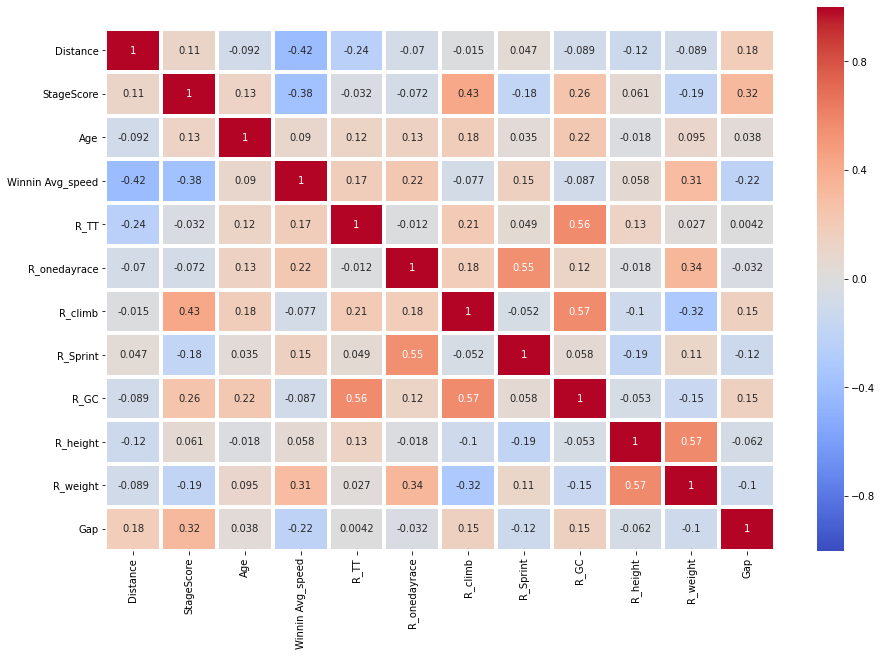

In [175]:
plt.figure(figsize=(15,10))
sns.heatmap(featcorr,cmap='coolwarm', center=0,annot=True, linewidths=3, vmin=-1, vmax=1)
# Don't worry about this, work-around for matplotlib issue where top
plt.ylim(len(featcorr.columns),-0.5, -0.5)

plt.show()

In [176]:
#First we create a matrix of zeroes that we will use like a mask to place over the upper triangle of our heatmap
mask = np.zeros_like(featcorr, dtype=np.bool)

# np.triu_indices_from returns the upper triangle, which we are setting to True
mask[np.triu_indices_from(mask)] = True

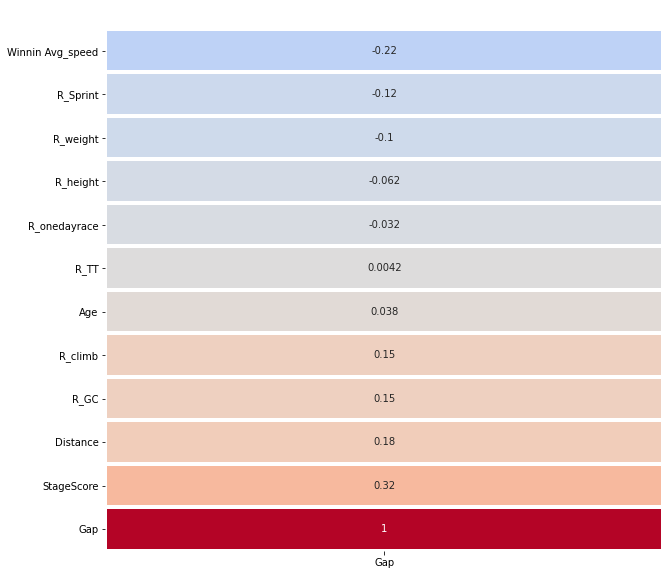

In [177]:
plt.figure(figsize=(10,10))
sns.heatmap(featcorr[['Gap']].sort_values(by='Gap'), cbar = False ,cmap='coolwarm', center=0, annot=True, linewidths = 3)
plt.ylim(len(featcorr.columns),-0.5, -0.5)
plt.show()

### Now, using just the winners of every stage and comparing the ones that did it in a breakaway as my target the correlations make much more sense, the stage score being the strongest, as I would expect from experience. 

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [181]:
winners.columns

Index(['Distance', 'StageScore', 'Age', 'Winnin Avg_speed', 'R_TT',
       'R_onedayrace', 'R_climb', 'R_Sprint', 'R_GC', 'R_height', 'R_weight',
       'Gap'],
      dtype='object')

In [190]:
# I already have my X an y defined, but I canb still play around with the traintest ratio

# Define our X and y
X = winners.drop(columns=['Gap'])
y = winners['Gap']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=1)

# Note that only the Train data is being oversampled
sm = SMOTE()
X_res, y_res = sm.fit_sample(X_train, y_train)


In [192]:
from sklearn import preprocessing
preprocessing.StandardScaler().fit(X_res)

# 1. Instantiate and fit model
my_logit = LogisticRegression()
my_logit.fit (X_res, y_res)

#predicttion on trainset
my_logit_pred=my_logit.predict(X_test)




# 3. Score model

print(classification_report(y_test, my_logit_pred))



              precision    recall  f1-score   support

           0       0.67      0.80      0.73        41
           1       0.53      0.36      0.43        25

    accuracy                           0.64        66
   macro avg       0.60      0.58      0.58        66
weighted avg       0.62      0.64      0.62        66



Now even the logistic regression performs much better

Let me try the Random Forest Classifier again

In [184]:
#Now lets see what we get from a ramdom forest classifier
estimators=range(1,60)
valScore=[]
valrecall=[]
testScore=[]
testrecall=[]
accuraccy=[]

for i in estimators:
    clf_rf = RandomForestClassifier(n_estimators=i)
    clf_rf.fit(X_res, y_res)
    
    y_pred=clf_rf.predict(X_test)

   
    valScore.append(clf_rf.score(X_test, y_test))
    valrecall.append(recall_score(y_test, clf_rf.predict(X_test)))
    
    testScore.append(clf_rf.score(X, y))
    testrecall.append(recall_score(y_test, clf_rf.predict(X_test)))
    
    accuraccy.append(metrics.accuracy_score(y_test, y_pred))

In [195]:
print(f'Test score: {max(testScore)}')
print(f'Valrecall: {max(valrecall)}')
print(f'ValScore: {max(valScore)}')
print(f'TestRecall: {max(testrecall)}')
print(F'Acurracy: {max(accuraccy)}')


Test score: 0.8789954337899544
Valrecall: 0.48
ValScore: 0.6060606060606061
TestRecall: 0.48
Acurracy: 0.6060606060606061


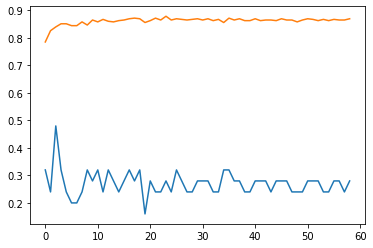

In [186]:
plt.figure()
plt.plot(testrecall)
plt.plot(testScore)
plt.show()

Since I don't have that much data now I want to try a stacking approach, this might improve my score for the minority class. 


In [198]:
y_train

12496     0
150499    0
132022    0
31485     0
22465     1
         ..
133200    0
8915      0
156816    1
32196     0
4118      0
Name: Gap, Length: 372, dtype: int64

### I also thought of running a stack approach and let the votes define the best model. 

In [203]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier 

In [207]:
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

pred1=model1.predict(X_test)
pred2=model2.predict(X_test)
pred3=model3.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, np.mean([pred1[i], pred2[i], pred3[i]]))

In [215]:
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

pred1=model1.predict_proba(X_test)
pred2=model2.predict_proba(X_test)
pred3=model3.predict_proba(X_test)

finalpred=(pred1+pred2+pred3)/3
#Check the max score for class 1, the minority class
max(finalpred[1])

0.560290441626105

### This did not improve much from the other models, I think for now I stick to the Log Regression, despite not entirely happy with the data set. 